In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")# Load the California Housing dataset
california_housing = fetch_california_housing()
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df['target'] = california_housing.target

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())# Basic statistical summary
print("Statistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (20640, 9)

Column Names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'target']

First 5 rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  fl

New features created:
   price_per_room  rooms_per_household  bedrooms_per_room  population_density  \
0        0.648041             2.732919           0.146591               0.126   
1        0.574691             2.956685           0.155797               1.138   
2        0.424824             2.957661           0.129516               0.177   
3        0.586693             2.283154           0.184458               0.219   
4        0.544744             2.879646           0.172096               0.259   

  age_category income_category          region  
0       Mature            High  Central Valley  
1       Modern            High  Central Valley  
2          Old            High  Central Valley  
3          Old          Medium  Central Valley  
4          Old          Medium  Central Valley  


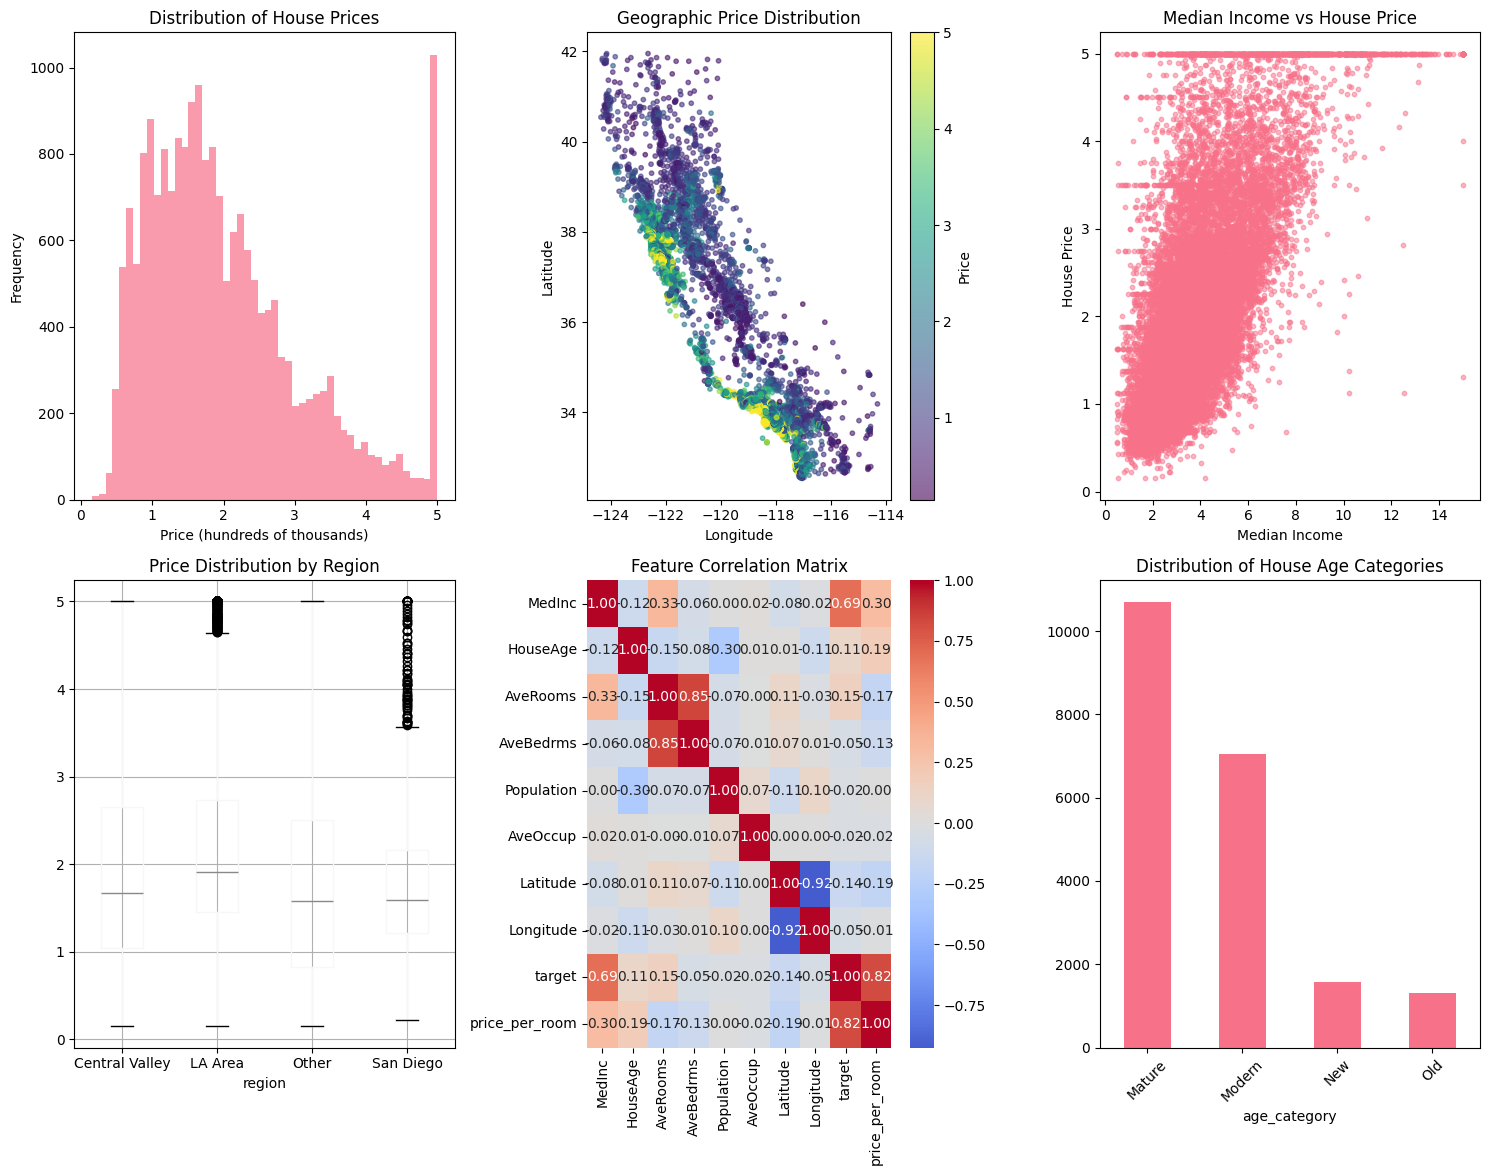

In [6]:
# Data Preparation & Feature Engineering
# Create additional features
df['price_per_room'] = df['target'] / df['AveRooms']
df['rooms_per_household'] = df['AveRooms'] / df['AveOccup']
df['bedrooms_per_room'] = df['AveBedrms'] / df['AveRooms']
df['population_density'] = df['Population'] / (df['AveOccup'] * 1000)

# Create age categories
df['age_category'] = pd.cut(df['HouseAge'],
                           bins=[0, 10, 25, 50, 100],
                           labels=['New', 'Modern', 'Mature', 'Old'])

# Create income categories
df['income_category'] = pd.cut(df['MedInc'],
                              bins=[0, 3, 6, 10, 15],
                              labels=['Low', 'Medium', 'High', 'Very High'])

# Create geographic regions based on lat/long
df['region'] = 'Other'
df.loc[(df['Latitude'] >= 37.5) & (df['Longitude'] <= -121.5), 'region'] = 'Bay Area'
df.loc[(df['Latitude'] <= 34.5) & (df['Longitude'] >= -118.5), 'region'] = 'LA Area'
df.loc[(df['Latitude'] <= 33) & (df['Longitude'] >= -117.5), 'region'] = 'San Diego'
df.loc[(df['Latitude'] >= 36.5) & (df['Longitude'] <= -119.5), 'region'] = 'Central Valley'

print("New features created:")
print(df[['price_per_room', 'rooms_per_household', 'bedrooms_per_room',
          'population_density', 'age_category', 'income_category', 'region']].head())

# Exploratory  Data Analysis with Visualizations
plt.figure(figsize=(15, 12))

# Target distribution
plt.subplot(2, 3, 1)
plt.hist(df['target'], bins=50, alpha=0.7)
plt.title('Distribution of House Prices')
plt.xlabel('Price (hundreds of thousands)')
plt.ylabel('Frequency')

# Geographic price distribution
plt.subplot(2, 3, 2)
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['target'],
                   cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Price')
plt.title('Geographic Price Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Income vs Price
plt.subplot(2, 3, 3)
plt.scatter(df['MedInc'], df['target'], alpha=0.5, s=10)
plt.title('Median Income vs House Price')
plt.xlabel('Median Income')
plt.ylabel('House Price')

# Price by region
plt.subplot(2, 3, 4)
df.boxplot(column='target', by='region', ax=plt.gca())
plt.title('Price Distribution by Region')
plt.suptitle('')

# Correlation heatmap
plt.subplot(2, 3, 5)
numeric_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
              'AveOccup', 'Latitude', 'Longitude', 'target', 'price_per_room']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')

# Age distribution
plt.subplot(2, 3, 6)
df['age_category'].value_counts().plot(kind='bar')
plt.title('Distribution of House Age Categories')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Handle outliers and prepare data for modeling
from scipy import stats

# Remove extreme outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to key features
df_clean = df.copy()
for col in ['target', 'MedInc', 'AveRooms', 'Population']:
    df_clean = remove_outliers(df_clean, col)

print(f"Original dataset size: {len(df)}")
print(f"After outlier removal: {len(df_clean)}")

# Encode categorical variables
le_age = LabelEncoder()
le_income = LabelEncoder()
le_region = LabelEncoder()

df_clean['age_category_encoded'] = le_age.fit_transform(df_clean['age_category'])
df_clean['income_category_encoded'] = le_income.fit_transform(df_clean['income_category'])
df_clean['region_encoded'] = le_region.fit_transform(df_clean['region'])# Model Development
# Prepare features and target
feature_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                'AveOccup', 'Latitude', 'Longitude', 'price_per_room',
                'rooms_per_household', 'bedrooms_per_room', 'population_density',
                'age_category_encoded', 'income_category_encoded', 'region_encoded']

X = df_clean[feature_cols]
y = df_clean['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Original dataset size: 20640
After outlier removal: 17722
Training set size: (14177, 15)
Test set size: (3545, 15)


XGBoost not available
Model Performance Comparison:
                      MSE    RMSE     MAE      R²
Linear Regression  0.0291  0.1705  0.1168  0.9660
Random Forest      0.0006  0.0247  0.0095  0.9993


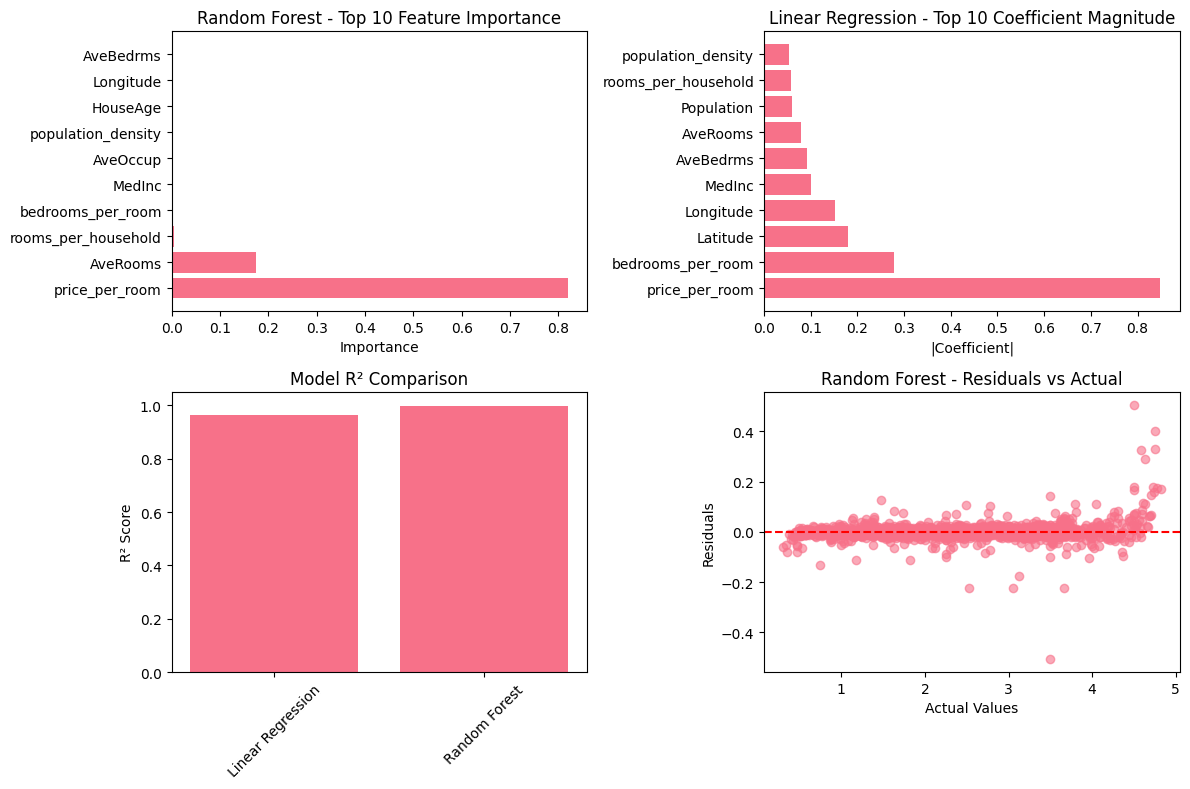

In [8]:
# Model Implementation and Evaluation
models = {}
results = {}

# 1. Linear Regression (Baseline)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
models['Linear Regression'] = lr

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
models['Random Forest'] = rf

# 3. XGBoost (if available)
try:
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    models['XGBoost'] = xgb_model
except ImportError:
    print("XGBoost not available")

# Calculate metrics for all models
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

results['Linear Regression'] = calculate_metrics(y_test, lr_pred)
results['Random Forest'] = calculate_metrics(y_test, rf_pred)
if 'XGBoost' in models:
    results['XGBoost'] = calculate_metrics(y_test, xgb_pred)

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df.round(4))# Feature Importance Analysis
plt.figure(figsize=(12, 8))

# Random Forest Feature Importance
plt.subplot(2, 2, 1)
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.barh(rf_importance['feature'][:10], rf_importance['importance'][:10])
plt.title('Random Forest - Top 10 Feature Importance')
plt.xlabel('Importance')

# Linear Regression Coefficients
plt.subplot(2, 2, 2)
lr_coef = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': abs(lr.coef_)
}).sort_values('coefficient', ascending=False)

plt.barh(lr_coef['feature'][:10], lr_coef['coefficient'][:10])
plt.title('Linear Regression - Top 10 Coefficient Magnitude')
plt.xlabel('|Coefficient|')

# Model comparison
plt.subplot(2, 2, 3)
model_names = list(results.keys())
r2_scores = [results[model]['R²'] for model in model_names]
plt.bar(model_names, r2_scores)
plt.title('Model R² Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

# Residual plot for best model
plt.subplot(2, 2, 4)
best_model = max(results.keys(), key=lambda x: results[x]['R²'])
if best_model == 'Linear Regression':
    residuals = y_test - lr_pred
elif best_model == 'Random Forest':
    residuals = y_test - rf_pred
else:
    residuals = y_test - xgb_pred

plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'{best_model} - Residuals vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

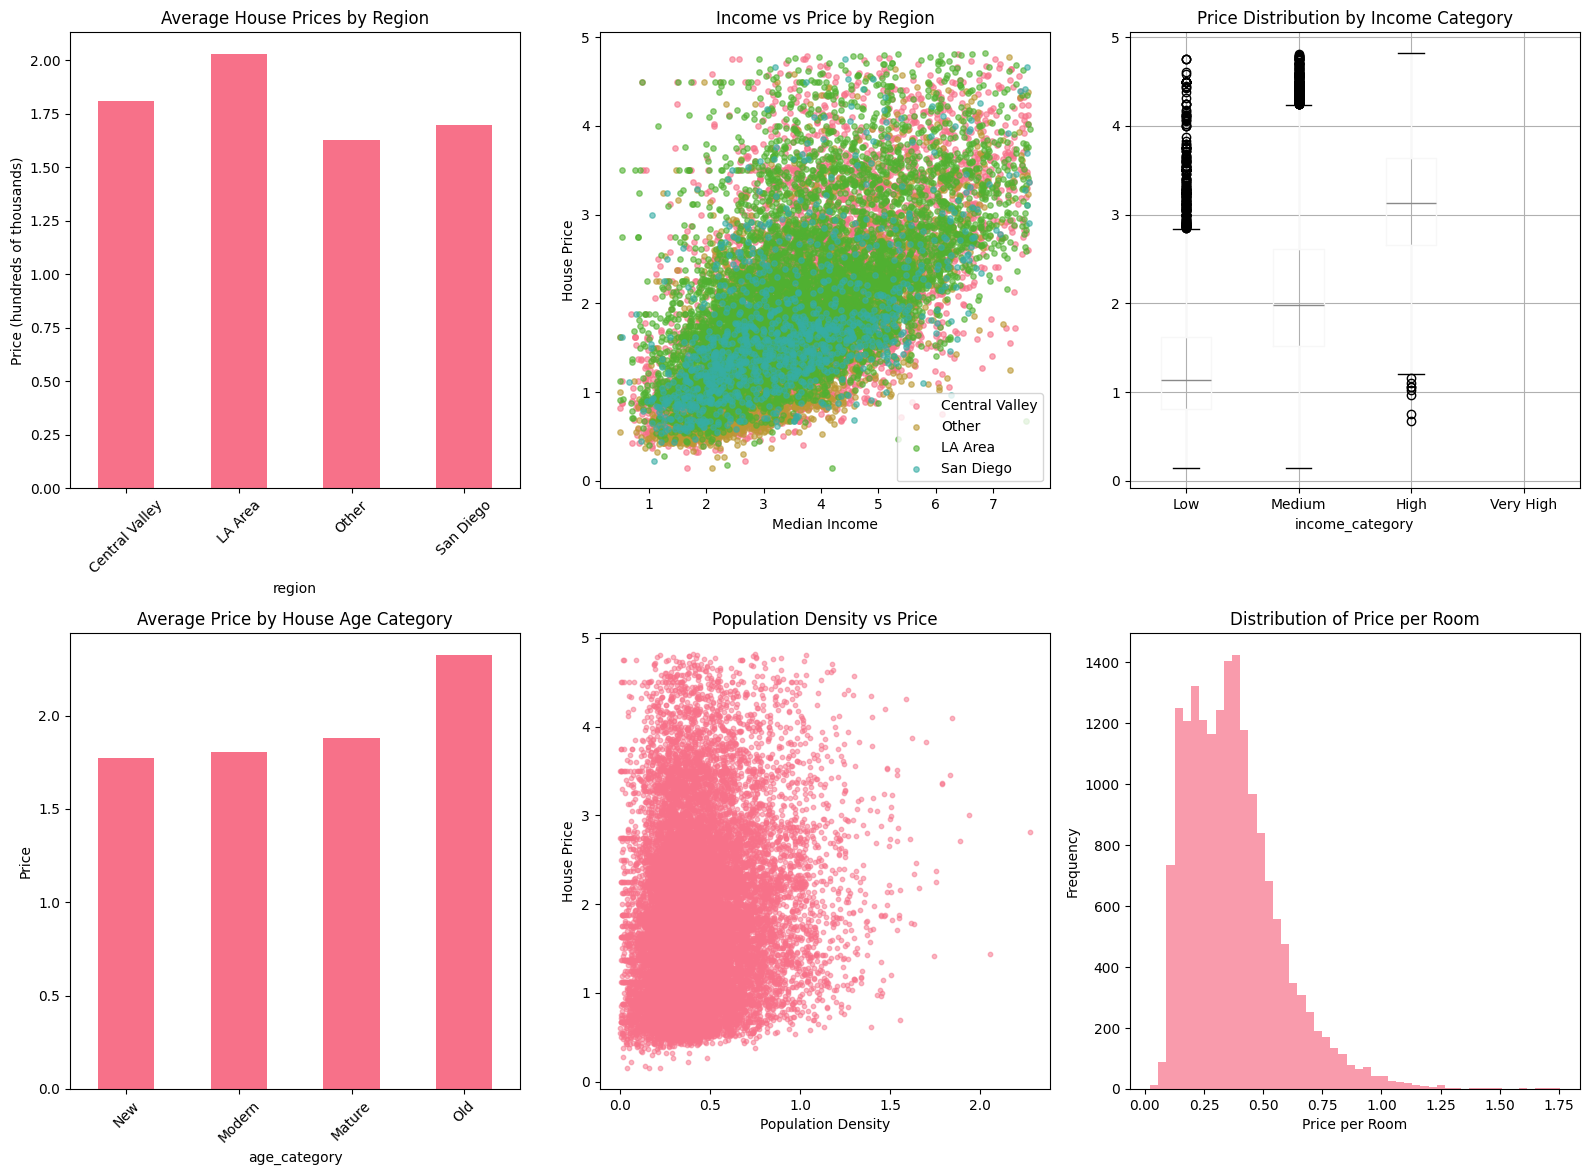


=== MARKET ANALYSIS INSIGHTS ===

Regional Analysis:
                mean  median   std
region                            
Central Valley  1.81    1.59  0.98
LA Area         2.03    1.86  0.87
Other           1.63    1.38  0.99
San Diego       1.70    1.55  0.77

Highest value region: LA Area
Most affordable region: Other

Key Value Drivers (Top 5):
                feature  importance
8        price_per_room    0.818921
2              AveRooms    0.174994
9   rooms_per_household    0.004918
10    bedrooms_per_room    0.000310
0                MedInc    0.000163

Model Performance Summary:
Best performing model: Random Forest
Best R² Score: 0.9993


In [9]:
# Market Analysis and Advanced Visualizations
plt.figure(figsize=(16, 12))

# Regional price analysis
plt.subplot(2, 3, 1)
regional_stats = df_clean.groupby('region')['target'].agg(['mean', 'median', 'std']).round(2)
regional_stats['mean'].plot(kind='bar')
plt.title('Average House Prices by Region')
plt.ylabel('Price (hundreds of thousands)')
plt.xticks(rotation=45)

# Income vs Price by Region
plt.subplot(2, 3, 2)
for region in df_clean['region'].unique():
    region_data = df_clean[df_clean['region'] == region]
    plt.scatter(region_data['MedInc'], region_data['target'],
               label=region, alpha=0.6, s=15)
plt.xlabel('Median Income')
plt.ylabel('House Price')
plt.title('Income vs Price by Region')
plt.legend()

# Price distribution by income category
plt.subplot(2, 3, 3)
df_clean.boxplot(column='target', by='income_category', ax=plt.gca())
plt.title('Price Distribution by Income Category')
plt.suptitle('')

# Age vs Price analysis
plt.subplot(2, 3, 4)
age_price = df_clean.groupby('age_category')['target'].mean()
age_price.plot(kind='bar')
plt.title('Average Price by House Age Category')
plt.ylabel('Price')
plt.xticks(rotation=45)

# Population density impact
plt.subplot(2, 3, 5)
plt.scatter(df_clean['population_density'], df_clean['target'], alpha=0.5, s=10)
plt.xlabel('Population Density')
plt.ylabel('House Price')
plt.title('Population Density vs Price')

# Price per room analysis
plt.subplot(2, 3, 6)
plt.hist(df_clean['price_per_room'], bins=50, alpha=0.7)
plt.title('Distribution of Price per Room')
plt.xlabel('Price per Room')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print market insights
print("\n=== MARKET ANALYSIS INSIGHTS ===")
print(f"\nRegional Analysis:")
print(regional_stats)

print(f"\nHighest value region: {regional_stats['mean'].idxmax()}")
print(f"Most affordable region: {regional_stats['mean'].idxmin()}")

print(f"\nKey Value Drivers (Top 5):")
print(rf_importance.head())

print(f"\nModel Performance Summary:")
print(f"Best performing model: {best_model}")
print(f"Best R² Score: {max([results[model]['R²'] for model in results.keys()]):.4f}")